In [12]:
import helper_classes.data_retriever as dr
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# NOTE: Retrieved data are all in the context of 2019 for pre-COVID19 Pandemic Purposes

# Data Retrieval
nyc_gdf = dr.retrieve_census_tiger_shapefile_dataframe()
sebg_df = dr.retrieve_socialexplorer_blockgroup_data()
networkx_df = dr.retrieve_networkx_result()

# Shapefile and Social Explorer Census Data Join
nyc_df = pd.merge(sebg_df, nyc_gdf, left_on='Geo_FIPS', right_on='GEOID')

# Prepare Geodata format for processing reasons
nyc_gdf = gpd.GeoDataFrame(nyc_df, geometry='geometry')
networkx_gdf = gpd.GeoDataFrame(
    networkx_df,
    geometry=gpd.points_from_xy(networkx_df.stop_lon, networkx_df.stop_lat)
    # crs=crs_text
)

# Remove parks and/or water via a filter
nyc_gdf = nyc_gdf[(nyc_gdf['ALAND'] > 0) & (nyc_gdf['ACS19_5yr_B01001001'] / nyc_gdf['ALAND'].apply(lambda x: pd.np.sqrt(x)) > 0.023)]

C:\Users\cjong\AppData\Local\Temp\ipykernel_22932\2447790784.py:25: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  nyc_gdf = nyc_gdf[(nyc_gdf['ALAND'] > 0) & (nyc_gdf['ACS19_5yr_B01001001'] / nyc_gdf['ALAND'].apply(lambda x: pd.np.sqrt(x)) > 0.023)]


In [14]:
# Create 500, 1000, 2000, and 5000 km radiuses

# Create a 1km buffer around the points in networkx_gdf
networkx_gdf_buffered = networkx_gdf.copy()

# Change the CRS to the desired CRS
# networkx_gdf_buffered = networkx_gdf_buffered.to_crs(crs_text)
networkx_gdf_buffered.geometry = networkx_gdf_buffered.buffer(0.03)

# Convert the buffered points to a GeoDataFrame
networkx_gdf_buffered = gpd.GeoDataFrame(networkx_gdf_buffered)

c:\Users\cjong\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\cjong\AppData\Local\Temp\ipykernel_22932\92496461.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4269
Right CRS: None

  joined_gdf = gpd.sjoin(nyc_gdf, networkx_gdf_buffered, how='inner', op='intersects').groupby(['GEOID'])[['btwn']].mean().reset_index()


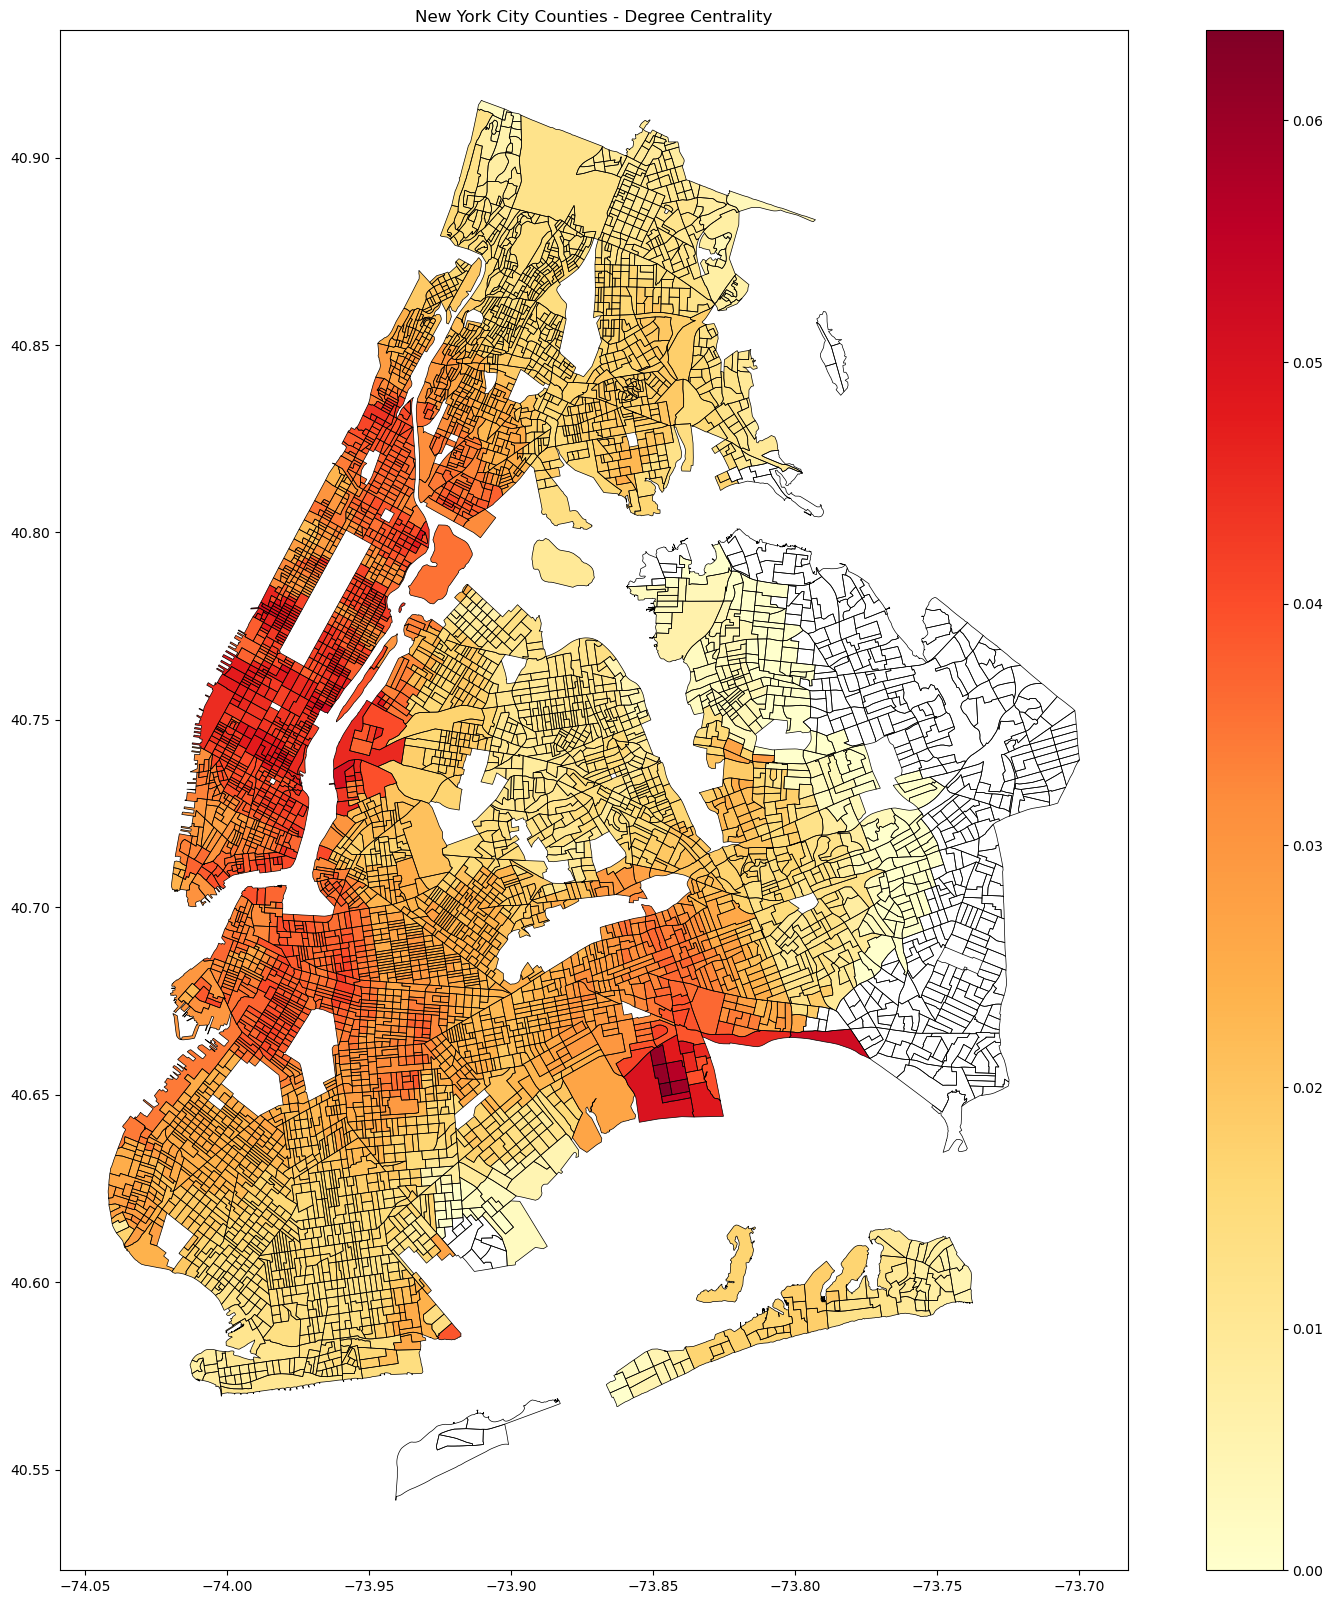

In [15]:
# Spatially join the two GeoDataFrames and aggregate the values of the 'column_to_summarize_1' and 'column_to_summarize_2' columns
joined_gdf = gpd.sjoin(nyc_gdf, networkx_gdf_buffered, how='inner', op='intersects').groupby(['GEOID'])[['btwn']].mean().reset_index()

# Merge joined_gdf and networkx_gdf_buffered on GEOID
joined_df = pd.merge(joined_gdf, nyc_gdf, on='GEOID')
joined_gdf = gpd.GeoDataFrame(joined_df, geometry='geometry')

# Create a choropleth map of New York City counties based on the degree centrality
fig, ax = plt.subplots(figsize=(20, 20))

# joined_gdf.plot(column='dgrs', cmap='YlOrRd', legend=True, ax=ax)
joined_gdf.plot(column='btwn', cmap='YlOrRd', legend=True, ax=ax)

# Add block group boundaries
nyc_gdf.plot(linewidth=0.5, edgecolor='black', facecolor='none', ax=ax)

# # Add circles for each point with the buffer radius as the circle's radius
# for point in networkx_gdf_buffered.itertuples():
#     ax.add_patch(Circle(xy=point.geometry.centroid.coords[0], radius=0.01, edgecolor='black', facecolor='none'))

ax.set_title('New York City Counties - Degree Centrality')
plt.show()

In [ ]:
nyc_gdf

,Geo_FIPS,Geo_NAME,Geo_QName,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_FILEID,Geo_LOGRECNO,Geo_US,Geo_REGION,...,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,360050001000,Block Group 0,"Block Group 0, Census Tract 1, Bronx County, N...",ny,150,0,ACSSF,8589,NaN,NaN,...,0,360050001000,Block Group 0,G5030,S,0,1035011,+40.7981690,-073.8916815,"POLYGON ((-73.89772 40.79514, -73.89611 40.796..."
1,360050001001,Block Group 1,"Block Group 1, Census Tract 1, Bronx County, N...",ny,150,0,ACSSF,8590,NaN,NaN,...,1,360050001001,Block Group 1,G5030,S,1677210,0,+40.7911136,-073.8826858,"POLYGON ((-73.89266 40.79382, -73.89194 40.796..."
2,360050002000,Block Group 0,"Block Group 0, Census Tract 2, Bronx County, N...",ny,150,0,ACSSF,8591,NaN,NaN,...,0,360050002000,Block Group 0,G5030,S,0,852046,+40.8035344,-073.8606612,"POLYGON ((-73.86648 40.80590, -73.86231 40.809..."
3,360050002001,Block Group 1,"Block Group 1, Census Tract 2, Bronx County, N...",ny,150,0,ACSSF,8592,NaN,NaN,...,1,360050002001,Block Group 1,G5030,S,89013,0,+40.8139633,-073.8608664,"POLYGON ((-73.86333 40.81478, -73.86240 40.814..."
4,360050002002,Block Group 2,"Block Group 2, Census Tract 2, Bronx County, N...",ny,150,0,ACSSF,8593,NaN,NaN,...,2,360050002002,Block Group 2,G5030,S,222104,0,+40.8116309,-073.8605956,"POLYGON ((-73.86522 40.81453, -73.86425 40.814..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6150,360811621002,Block Group 2,"Block Group 2, Census Tract 1621, Queens Count...",ny,150,0,ACSSF,20275,NaN,NaN,...,2,360811621002,Block Group 2,G5030,S,130861,0,+40.7292723,-073.7338903,"POLYGON ((-73.73714 40.72897, -73.73659 40.730..."
6151,360811621003,Block Group 3,"Block Group 3, Census Tract 1621, Queens Count...",ny,150,0,ACSSF,20276,NaN,NaN,...,3,360811621003,Block Group 3,G5030,S,118070,0,+40.7285528,-073.7293231,"POLYGON ((-73.73161 40.72789, -73.73160 40.727..."
6152,360811621004,Block Group 4,"Block Group 4, Census Tract 1621, Queens Count...",ny,150,0,ACSSF,20277,NaN,NaN,...,4,360811621004,Block Group 4,G5030,S,118697,0,+40.7279191,-073.7258934,"POLYGON ((-73.72760 40.72814, -73.72689 40.729..."
6153,360811621005,Block Group 5,"Block Group 5, Census Tract 1621, Queens Count...",ny,150,0,ACSSF,20278,NaN,NaN,...,5,360811621005,Block Group 5,G5030,S,159750,0,+40.7251226,-073.7280772,"POLYGON ((-73.73149 40.72742, -73.73088 40.727..."
